In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1
import datatable as dt

# system
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

import lightgbm as lgb

import numpy as np
from scipy.stats import norm
import pandas as pd
pd.set_option('display.max_columns', 500)

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer,QuantileTransformer,normalize,MaxAbsScaler
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.utils import class_weight

from time import time
from tqdm import tqdm
import gc,datetime

import janestreet

In [2]:
# Options

TRAINING = True

# seed set
SEED = 2021
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Reading

In [3]:
folder_path = '../input/jane-street-market-prediction/'
#save_path = '../input/jane-autoencorder/'

In [4]:
# Reading csv
print('Reading train.csv')
train = dt.fread(folder_path + 'train.csv').to_pandas()

print('Finish Reading')

Reading train.csv
Finish Reading


In [5]:
# Reading csv
print('Reading train.csv')
tag_feature = dt.fread(folder_path + 'features.csv').to_pandas()
tag_feature = tag_feature.set_index('feature')
tag_feature = tag_feature.astype('int8')
print('Finish Reading')

Reading train.csv
Finish Reading


## Pre-processing

In [6]:
# Pre-process
print('Pre-process start')
train['feature_0'] = train['feature_0'].astype(np.int8)
train['date'] = train['date'].astype(np.int16)
train['ts_id'] = train['ts_id'].astype(np.int32)

train = train[train['weight'] > 0.0].reset_index(drop=True)
#train = train[train['date'] > 199].reset_index(drop=True)

Pre-process start


In [7]:
#limit memory use
train = train.astype({c: np.float32 for c in train.select_dtypes(include='float64').columns})

In [8]:
pre_features = [c for c in train.columns if "feature" in c]

In [9]:
f_mean = np.mean(train[pre_features[1:]].values,axis=0)

train.fillna(train.mean(),inplace=True)

In [10]:
# action = 0とするresp(=featureのリターン)を学習させるターゲットとする
train['action'] = (train['resp']> 0.0).astype('int8')
#train['action_1'] = (train['resp']> 0.05).astype('int8')
#train['action_2'] = (train['resp']> 0.1).astype('int8')
#train['action_3'] = (train['resp']> 0.2).astype('int8')

# features
#features = [c for c in train.columns if "feature" in c]
#features = [c for c in train.columns if "feature_tag" in c]

features = [f'feature_{c}' for c in range(130)]
#target = ['action','action_1','action_2','action_3']
target = ['action']

train['weight_resp'] = abs(train['resp'])*train['weight']
train['weight_bin'] = pd.cut(train['weight_resp'], [0, 0.0085, 500],labels=[0.9, 1.5]).astype(np.float32) #1 9551211 2 506620 3 345281 5 174265

weight = ['weight_bin']

In [11]:
print(train['weight_bin'].value_counts())

0.9    992573
1.5    988714
Name: weight_bin, dtype: int64


In [12]:
print(train['action'].value_counts())
#print(train['action_1'].value_counts())
#print(train['action_2'].value_counts())
#print(train['action_3'].value_counts())

1    999387
0    981900
Name: action, dtype: int64


## Metric

In [13]:
def utility_score_numba(date, weight, resp, action):
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / len(Pi))
    u = min(max(t, 0), 6) * np.sum(Pi)
    return u

def jane_utility(data, action_column="action"):
    return utility_score_numba(data["date"].values, data["weight"].values, data["resp"].values, data[action_column].values)

## Model

In [14]:
def create_mlp(input_dim, output_dim, label_smoothing, learning_rate, tag):

    input1 = Input(input_dim)
    
    x = BatchNormalization()(input1)
    
    xt = tf.matmul(x, tag)
    x = Concatenate()([x,xt])
    
    x = tf.keras.layers.Dense(150)(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = BatchNormalization()(x)
    x = tf.keras.layers.Dense(150)(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = BatchNormalization()(x)
    x = tf.keras.layers.Dense(150)(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    out = Dense(output_dim, activation='sigmoid')(x)
   
    model = Model(inputs=input1, outputs=out)
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
        metrics = tf.keras.metrics.AUC(name="AUC"),
        sample_weight_mode=None,
        weighted_metrics=['AUC'],
    )

    return model

# Traning,Validation

In [15]:
X_train = train.loc[(train['date'] >= 85) & (train['date'] < 250),features].values
y_train = train.loc[(train['date'] >= 85) & (train['date'] < 250),target].values
weight_train = train.loc[(train['date'] >= 85) & (train['date'] < 250),weight].values

X_train2 = train.loc[(train['date'] >= 85) & (train['date'] < 450),features].values
y_train2 = train.loc[(train['date'] >= 85) & (train['date'] < 450),target].values
weight_train2 = train.loc[(train['date'] >= 85) & (train['date'] < 450),weight].values

X_valid = train.loc[(train['date'] >= 450) & (train['date'] < 500),features].values
y_valid = train.loc[(train['date'] >= 450) & (train['date'] < 500),target].values
weight_valid = train.loc[(train['date'] >= 450) & (train['date'] < 500),weight].values
        
    
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_train2:',X_train2.shape)
print('y_train2:',y_train2.shape)
print('X_valid:',X_valid.shape)
print('y_valid:',y_valid.shape)

X_train: (549967, 130)
y_train: (549967, 1)
X_train2: (1345102, 130)
y_train2: (1345102, 1)
X_valid: (236056, 130)
y_valid: (236056, 1)


In [16]:
epochs = 1000
batch_size = 512
label_smoothing = 0.01
learning_rate = 0.001
verbose = 1

opt_th = 0.500

if TRAINING:
    start_time_fold = time()
    ckp_path = 'JSResNet.hdf5'
        
    model = create_mlp(len(features), len(target), label_smoothing, learning_rate, tag_feature)
    
    rlr = ReduceLROnPlateau(monitor = 'val_AUC', factor = 0.1, patience = 3, verbose = verbose, min_delta = 1e-4, mode = 'max')
    ckp = ModelCheckpoint(ckp_path, monitor = 'val_AUC', verbose = 0, save_best_only = True, save_weights_only = True, mode = 'max')
    es = EarlyStopping(monitor = 'val_AUC', min_delta = 1e-4, patience = 5, mode = 'max', baseline = None, restore_best_weights = True, verbose = 0)
    
    history = model.fit(X_train,
                        y_train,
                        sample_weight = weight_train,
                        epochs = epochs,
                        validation_data = (X_valid,y_valid),
                        batch_size = batch_size,
                        callbacks = [rlr, ckp, es],
                        verbose = verbose)
    
    hist = pd.DataFrame(history.history)
    print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[0:7]}] ROC AUC:\t', hist['val_AUC'].max())
        
    # validation
    Valid = train[(train['date'] >= 450) & (train['date'] < 500)]

    predictions = np.zeros(X_valid.shape[0])
    predictions = model(X_valid, training = False).numpy()
        
    Valid.action = np.where(predictions >= opt_th, 1, 0).astype('int8')
        
    print("Valid Jane Utility: {:.2f}".format(jane_utility(train[(train['date'] >= 450) & (train['date'] < 500)], action_column="action")))
    print("Pred  Jane Utility: {:.2f}".format(jane_utility(Valid, action_column="action")))
    print('auc:{:.3f}'.format(roc_auc_score(train[(train['date'] >= 450) & (train['date'] < 500)].action.values, predictions)))
    print('accuracy:{:.3f}'.format(accuracy_score(train[(train['date'] >= 450) & (train['date'] < 500)].action.values, Valid.action.values)))
    print('precision:{:.3f}'.format(precision_score(train[(train['date'] >= 450) & (train['date'] < 500)].action.values, Valid.action.values)))
    print('recall:{:.3f}'.format(recall_score(train[(train['date'] >= 450) & (train['date'] < 500)].action.values, Valid.action.values)))
    
    K.clear_session()
    del X_train, y_train, Valid
    gc.collect()

Epoch 1/1000
1075/1075 [==============================] - 9s 8ms/step - loss: 0.8304 - AUC: 0.5156 - auc: 0.5172 - val_loss: 0.6921 - val_AUC: 0.5283 - val_auc: 0.5283
Epoch 2/1000
1075/1075 [==============================] - 8s 8ms/step - loss: 0.8227 - AUC: 0.5301 - auc: 0.5329 - val_loss: 0.6917 - val_AUC: 0.5293 - val_auc: 0.5293
Epoch 3/1000
1075/1075 [==============================] - 8s 7ms/step - loss: 0.8214 - AUC: 0.5352 - auc: 0.5385 - val_loss: 0.6922 - val_AUC: 0.5250 - val_auc: 0.5250
Epoch 4/1000
1075/1075 [==============================] - 9s 8ms/step - loss: 0.8198 - AUC: 0.5413 - auc: 0.5450 - val_loss: 0.6925 - val_AUC: 0.5295 - val_auc: 0.5295
Epoch 5/1000
1075/1075 [==============================] - 8s 7ms/step - loss: 0.8180 - AUC: 0.5453 - auc: 0.5495 - val_loss: 0.6950 - val_AUC: 0.5239 - val_auc: 0.5239
Epoch 6/1000
1075/1075 [==============================] - 8s 7ms/step - loss: 0.8159 - AUC: 0.5500 - auc: 0.5547 - val_loss: 0.6957 - val_AUC: 0.5232 - val_auc:

In [17]:
if TRAINING:
    start_time_fold = time()

    model = create_mlp(len(features), len(target), label_smoothing, learning_rate/10, tag_feature)
    
    model.load_weights(ckp_path)
    es = EarlyStopping(monitor = 'val_AUC', min_delta = 1e-4, patience = 5, mode = 'max', baseline = None, restore_best_weights = True, verbose = 0)

    history2 = model.fit(X_train2,
                         y_train2,
                         sample_weight = weight_train2,
                         validation_data = (X_valid, y_valid),
                         batch_size = batch_size,epochs = 1000,
                         callbacks = [es],
                         verbose = verbose)

    hist2 = pd.DataFrame(history2.history)
    print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[0:7]}] ROC AUC:\t', hist2['val_AUC'].max())
    finetune_epochs = hist2['val_AUC'].argmax() + 1
    
    # validation
    Valid = train[(train['date'] >= 450) & (train['date'] < 500)]

    predictions = np.zeros(X_valid.shape[0])
    predictions = model(X_valid, training = False).numpy()
        
    Valid.action = np.where(predictions >= opt_th, 1, 0).astype('int8')
        
    print("Valid Jane Utility: {:.2f}".format(jane_utility(train[(train['date'] >= 450) & (train['date'] < 500)], action_column="action")))
    print("Pred  Jane Utility: {:.2f}".format(jane_utility(Valid, action_column="action")))
    print('auc:{:.3f}'.format(roc_auc_score(train[(train['date'] >= 450) & (train['date'] < 500)].action.values, predictions)))
    print('accuracy:{:.3f}'.format(accuracy_score(train[(train['date'] >= 450) & (train['date'] < 500)].action.values, Valid.action.values)))
    print('precision:{:.3f}'.format(precision_score(train[(train['date'] >= 450) & (train['date'] < 500)].action.values, Valid.action.values)))
    print('recall:{:.3f}'.format(recall_score(train[(train['date'] >= 450) & (train['date'] < 500)].action.values, Valid.action.values)))

    K.clear_session()
    del model
    rubbish = gc.collect()

Epoch 1/1000
2628/2628 [==============================] - 18s 7ms/step - loss: 0.8253 - AUC: 0.5344 - auc: 0.5374 - val_loss: 0.6915 - val_AUC: 0.5325 - val_auc: 0.5325
Epoch 2/1000
2628/2628 [==============================] - 17s 6ms/step - loss: 0.8245 - AUC: 0.5377 - auc: 0.5411 - val_loss: 0.6915 - val_AUC: 0.5335 - val_auc: 0.5335
Epoch 3/1000
2628/2628 [==============================] - 17s 7ms/step - loss: 0.8240 - AUC: 0.5394 - auc: 0.5430 - val_loss: 0.6915 - val_AUC: 0.5333 - val_auc: 0.5333
Epoch 4/1000
2628/2628 [==============================] - 17s 6ms/step - loss: 0.8235 - AUC: 0.5412 - auc: 0.5449 - val_loss: 0.6914 - val_AUC: 0.5348 - val_auc: 0.5348
Epoch 5/1000
2628/2628 [==============================] - 17s 7ms/step - loss: 0.8231 - AUC: 0.5428 - auc: 0.5466 - val_loss: 0.6914 - val_AUC: 0.5359 - val_auc: 0.5359
Epoch 6/1000
2628/2628 [==============================] - 18s 7ms/step - loss: 0.8228 - AUC: 0.5436 - auc: 0.5475 - val_loss: 0.6917 - val_AUC: 0.5352 - va

In [18]:
if TRAINING:
    start_time_fold = time()
    
    model = create_mlp(len(features), len(target), label_smoothing, learning_rate / 100, tag_feature)
    model.load_weights(ckp_path)
    model.fit(X_valid,
              y_valid,
              sample_weight = weight_valid,
              batch_size = batch_size,
              epochs = finetune_epochs,
              verbose = verbose)
    
    model.save_weights(ckp_path)

    K.clear_session()
    del model, X_train2, y_train2, X_valid, y_valid
    rubbish = gc.collect()

Epoch 1/5
462/462 [==============================] - 3s 7ms/step - loss: 0.8275 - AUC: 0.5259 - auc: 0.5286
Epoch 2/5
462/462 [==============================] - 3s 7ms/step - loss: 0.8266 - AUC: 0.5296 - auc: 0.5323
Epoch 3/5
462/462 [==============================] - 3s 6ms/step - loss: 0.8256 - AUC: 0.5316 - auc: 0.5344
Epoch 4/5
462/462 [==============================] - 3s 6ms/step - loss: 0.8251 - AUC: 0.5338 - auc: 0.5370
Epoch 5/5
462/462 [==============================] - 3s 6ms/step - loss: 0.8248 - AUC: 0.5342 - auc: 0.5372


In [19]:
model = create_mlp(len(features), len(target), label_smoothing, learning_rate, tag_feature)
model.load_weights('./JSResNet.hdf5')

## Inference

In [20]:
Inf = True

In [21]:
# Inference
if Inf:

    env = janestreet.make_env()

    for (test_df, pred_df) in tqdm(env.iter_test()):
        
        if test_df['weight'].item() > 0:
            x_tt = test_df.loc[:, features].values
        
            if np.isnan(x_tt[:, 1:].sum()):
                x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
        
            pred = model(x_tt, training = False).numpy()
            pred_df.action = np.where(pred >= opt_th, 1, 0).astype(int)
        
        env.predict(pred_df)
else:
    print('Traning Done')

15219it [04:04, 62.21it/s]


In [22]:
if Inf:
    # display submission.csv
    submission = pd.read_csv('./submission.csv')
    print(submission.action.value_counts())

1    8185
0    7034
Name: action, dtype: int64


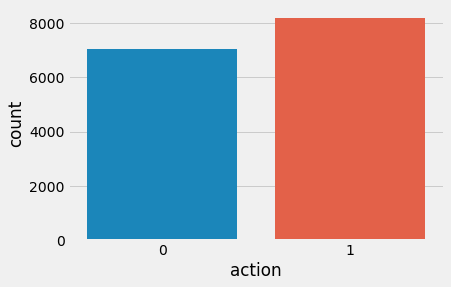

In [23]:
if Inf:
    sns.countplot(submission.action);